In [16]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import math

In [3]:
def check_interleaved_metrics(df, metric_a, metric_b, verbose=False):
    """
    Checks whether metric_a and metric_b are logged in alternating rows in the DataFrame.

    Args:
        df (pd.DataFrame): W&B history DataFrame.
        metric_a (str): Name of the first metric (e.g., "avg_flesch_kincaid_store").
        metric_b (str): Name of the second metric (e.g., "train/reward").
        verbose (bool): If True, prints mismatches.

    Returns:
        bool: True if metrics alternate every other row starting with metric_a.
    """
    a_logged = df[metric_a].notna()
    b_logged = df[metric_b].notna()

    is_alternating = True
    for i in range(len(df)):
        if i % 2 == 0:  # Expect metric_a
            if not a_logged.iloc[i] or b_logged.iloc[i]:
                is_alternating = False
                if verbose:
                    print(f"Row {i}: Expected {metric_a}, got {df.iloc[i][[metric_a, metric_b]].to_dict()}")
        else:  # Expect metric_b
            if not b_logged.iloc[i] or a_logged.iloc[i]:
                is_alternating = False
                if verbose:
                    print(f"Row {i}: Expected {metric_b}, got {df.iloc[i][[metric_a, metric_b]].to_dict()}")
    return is_alternating

def drop_trailing_nan_row(df, metrics_of_interest=[ "avg_flesch_kincaid_score", "train/reward"]):
    if df[metrics_of_interest].tail(1).isna().all(axis=1).bool():
        return df.iloc[:-1]
    return df

def get_metrics(run_id, get_only_reward=True, project='GRPO_DIFFICULTY'):
    # Replace with your actual entity, project, and run ID
    run_path = f"{project}/{run_id}"  

    api = wandb.Api()
    run = api.run(run_path)

    # # Download the history
    history = run.history(samples=100000)  # increase samples if your run is long

    if get_only_reward:
        #df = history[["train/reward"]].dropna().reset_index(drop=True)

        # # 1. Drop rows with missing reward
        df =  history[["train/reward", 'train/global_step']]
        df = df[df['train/reward'].notnull()]

        # # 2. Keep only the last entry per global_step
        df = df.groupby('train/global_step', as_index=False).last().reset_index(drop=True)
    else:
        # Reset index for clean pairing
        history = drop_trailing_nan_row(history.reset_index(drop=True))
        assert check_interleaved_metrics(history, "avg_flesch_kincaid_score", "train/reward", verbose=True)

        # Split into even and odd rows
        even_rows = history.iloc[::2].reset_index(drop=True)
        odd_rows = history.iloc[1::2].reset_index(drop=True)

        assert even_rows.shape[0] == odd_rows.shape[0]

        # Merge them
        df = pd.DataFrame({
            "avg_flesch_kincaid_score": even_rows["avg_flesch_kincaid_score"].values,
            "train/reward": (odd_rows["train/reward"].values).astype(int)
        }).dropna()

    num_gen = run.config['num_generations']
    df['train/reward'] = (df['train/reward'] * num_gen).astype(int)
    df['cumsum'] = df['train/reward'].cumsum()
    last_10_mean = np.mean(history['train/reward'].dropna().tail(10).values)
    return df, last_10_mean, history, run.name

def get_elbow_point(df_):
    x = df_.index.values
    y = df_['cumsum'].values

    # 1. Normalize
    x_n = (x - x.min()) / (x.max() - x.min())
    y_n = (y - y.min()) / (y.max() - y.min())

    # 2–3. Distances to the line y = x
    dists = np.abs(y_n - x_n) / np.sqrt(2)

    # 4. Elbow index
    elbow_idx = np.argmax(dists)
    elbow_step = int(x[elbow_idx])

    elbow_val = int(y[elbow_step])
    return elbow_val, elbow_step

In [ ]:
# thresh_numgen_trainsteps : (run_id, was_successful)
all_runs = {
    '2.5_16_2k': ('ljeeoj7b', False),
    '3_4_1k' : ('lnbetlnx', False),
    '4.11_4_1k' : ('mk92tz6t', False),
    '4.11_4_5k' : ('niwyns0h', True),
    '4.11_8_2.2k' : ('44o641zt', True),
    '4.11_16_1k' : ('9cjurtq3', True),
    '4.63_4_1k' : ('ahyurqae', False),
    '4.63_8_1k' : ('ddmediaw', True),
    '5.12_4_1k' : ('id5d33m6', True),

    '5.39_4_1k' : ('g97n7tjc', True),
    '5.97_4_1k' : ('1q5k2yz2', True),
    
}

fig, axarr = plt.subplots(math.ceil(len(all_runs) / 3), 3, figsize=(24,20))
axarr = axarr.flatten()

for i, (name, info) in enumerate(all_runs.items()):
    run_id, succeed = info
    num_gen = int(name.split('_')[1])
    thresh = float(name.split('_')[0])
    dur = name.split('_')[2]
    result_df, mean_end_reward, _, _ = get_metrics(run_id, num_gen=num_gen)
    total_ = int(result_df['cumsum'].iloc[-1])
    title_ = f'Thresh={thresh} at {num_gen} iters\n'
    print(title_)
    print(f'Saw {total_} successful runs, {len(result_df)} <-> {dur}')
    if succeed:
        num_success_seen, when_saw = get_elbow_point(result_df)
        print(f'Num where started to succeed: {num_success_seen}, after {when_saw} steps: {when_saw*num_gen} seen')
    else:
        print(f'Did not succeed: saw {num_gen*len(result_df)}')
    print('----')
    axarr[i].scatter(np.arange(len(result_df)), result_df['cumsum'].values)
    if succeed:
        axarr[i].axvline(when_saw, color='red', linestyle='--', label='Elbow (Piecewise)')
        axarr[i].set_title(f'{title_}increase after {num_success_seen} successes', fontsize=20)
        axarr[i].legend()
    else:
        axarr[i].set_title(f'{title_}did not succeed', fontsize=20)
    axarr[i].set_xlabel('Steps', fontsize=18)
    axarr[i].set_ylabel('# Successful Examples Seen', fontsize=18)
    #axarr[i].set_ylim([0,500])
plt.tight_layout()

In [ ]:
result_df, mean_end_reward, history = get_metrics('cxkojwo1', num_gen=8)

total_ = int(result_df['cumsum'].iloc[-1])
print(f'Saw {total_} successful runs, {len(result_df)}')

num_success_seen, when_saw = get_elbow_point(result_df)

print(f'Num where started to succeed: {num_success_seen}, after {when_saw} steps: {when_saw*8} seen')
plt.scatter(np.arange(len(result_df)), result_df['cumsum'].values)
plt.axvline(when_saw, color='red', linestyle='--', label='Elbow (Piecewise)')
plt.title(f'increase after {num_success_seen} successes', fontsize=20)
plt.legend()
plt.xlabel('Steps', fontsize=18)
plt.ylabel('# Successful Examples Seen', fontsize=18)
#axarr[i].set_ylim([0,500])
plt.tight_layout()

/var/folders/zq/7j74swb90ygby0pfbdm44mgw0000gn/T/ipykernel_53991/3315744881.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(run_ids))


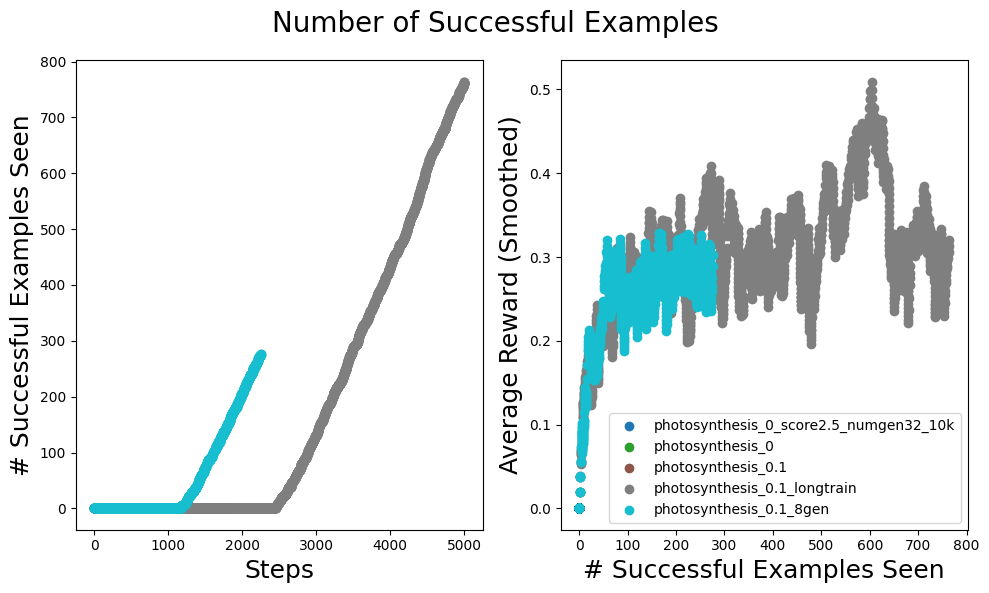

In [23]:
def plot_metrics(run_ids: list[str], plot_success_line: bool = False):
    cmap = cm.get_cmap('tab10', len(run_ids))
    colors = [cmap(i) for i in range(len(run_ids))]  # List of RGBA colors
    fig, axarr = plt.subplots(1,2,figsize=(10,6))
    axarr[0].set_xlabel('Steps', fontsize=18)
    axarr[0].set_ylabel('# Successful Examples Seen', fontsize=18)
    axarr[1].set_xlabel('# Successful Examples Seen', fontsize=18)
    axarr[1].set_ylabel('Average Reward (Smoothed)', fontsize=18)


    for color, run_id in zip(colors,run_ids):
        result_df, mean_end_reward, history, run_name = get_metrics(run_id) 
        result_df['ema'] = result_df['train/reward'].ewm(span=100,adjust=False).mean()
        #total_ = int(result_df['cumsum'].iloc[-1])
        #print(f'{run_id} saw {total_} successful runs, {len(result_df)}')
        axarr[0].scatter(np.arange(len(result_df)), result_df['cumsum'].values, label=run_name, color=color)
        axarr[1].scatter(result_df['cumsum'].values, result_df['ema'].values, label=run_name, color=color)
        

        if plot_success_line:
            num_success_seen, when_saw = get_elbow_point(result_df)
            axarr[0].axvline(when_saw, color=color, linestyle='--', label='Elbow (Piecewise)')
            #axarr[0].set_title(f'{title_}increase after {num_success_seen} successes', fontsize=20)
            axarr[0].legend()

    #plt.axvline(when_saw, color='red', linestyle='--', label='Elbow (Piecewise)')
    fig.suptitle(f'Number of Successful Examples', fontsize=20)
    axarr[1].legend()

    #axarr[i].set_ylim([0,500])
    plt.tight_layout()
plot_metrics(['ljeeoj7b','lnbetlnx','mk92tz6t', 'niwyns0h', '44o641zt'])

4